In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("torch.cuda.is_available():", torch.cuda.is_available())

torch.cuda.is_available(): True


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import evaluate
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import (
    AutoImageProcessor,
    ViTFeatureExtractor,
    ViTForImageClassification,
    ViTImageProcessor,
    ViTForImageClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# Data Pipeline

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")
print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [00:42<00:00, 246MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [ ]:
!cp -r {path} /content/drive/MyDrive/kaggle_dataset1

^C


In [ ]:
!ls "/content/drive/MyDrive/dl_models"

custom_cnn.h5	    dl_hw3_resnet50.h5	submission.csv
dl_hw3_effnetb0.h5  kagglecomp_vit.h5	vit_output


In [ ]:
root_dir = path
train_csv_path = os.path.join(root_dir, "train.csv")
test_csv_path = os.path.join(root_dir, "test.csv")
pd.read_csv(train_csv_path).columns

Index(['Unnamed: 0', 'file_name', 'label'], dtype='object')

In [ ]:
df = pd.read_csv(train_csv_path)
final_pred_df = pd.read_csv(test_csv_path) # test data is saved for final prediction
print("Given Train set length:", len(df))
print("Given Test set length:", len(final_pred_df))
print("Given Train set columns:", df.columns.tolist())
print("Given Test set columns:", final_pred_df.columns.tolist())

Given Train set length: 79950
Given Test set length: 5540
Given Train set columns: ['Unnamed: 0', 'file_name', 'label']
Given Test set columns: ['id']


In [ ]:
# Stratify sampling of the entire train and validation sets
train_df, val_df = train_test_split(
    df,
    test_size=0.1,  # 10% for validation
    stratify=df["label"],
    random_state=42  # For reproducibility
)

print("Training set length:", len(train_df))
print("Validation set length:", len(val_df))
#print("Test set length:", len(test_df))
#print("Leftover (unused) length:", len(leftover_df))

Training set length: 71955
Validation set length: 7995


In [ ]:
print("Training dataframe columns:", train_df.columns.tolist())
print("Validation dataframe columns:", val_df.columns.tolist())

Training dataframe columns: ['Unnamed: 0', 'file_name', 'label']
Validation dataframe columns: ['Unnamed: 0', 'file_name', 'label']


In [ ]:
class ImageDataset(Dataset):
    """
    Custom dataset that:
      - Reads image paths + labels from a dataframe
      - Loads each image
      - Processes it with a ViTImageProcessor
      - Returns a dictionary { "pixel_values": tensor, "labels": label }
    """
    def __init__(self, df, root_dir, image_processor, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]           # get the row from the csv vile
        img_name = row["file_name"] # get the image path column
        label = row["label"]         # get the label

        # Build full path and open the image
        img_path = os.path.join(self.root_dir, img_name) # get the image path

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Optional transforms (e.g., random crop) - if needed
        if self.transform:
            image = self.transform(image)

        # Apply the ViT image processor
        # This will handle resizing, normalization, etc.
        processed = self.image_processor(image, return_tensors="pt")

        # processed["pixel_values"] is a 1 x C x H x W tensor
        # We want to remove the batch dimension here, so we do processed["pixel_values"].squeeze(0)
        pixel_values = processed["pixel_values"].squeeze(0)

        return {
            "pixel_values": pixel_values,  # torch.Size([3, 224, 224]) typically
            "labels": label
        }

In [ ]:
# Create a ViT image processor
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define transformation for resizing and augmenting images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the original image to ViT input size
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),  # Rotate images slightly
])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# Create datasets and dataloaders for training and validation sets
train_dataset = ImageDataset(df=train_df, root_dir=root_dir, image_processor=image_processor, transform=transform)
val_dataset = ImageDataset(df=val_df, root_dir=root_dir, image_processor=image_processor, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# See train loader
for batch in train_loader:
    print(batch)
    break

{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1

# Modeling

### Baseline

Vision Transformer (ViT) is a deep learning model that applies self-attention (Transformers) to image classification instead of using traditional CNNs (e.g., ResNet, EfficientNet). ViT divides an image into patches (instead of pixels) and processes them like words in NLP.

🔹 Key ideas behind ViT:
- Patch-based processing: Instead of convolution filters, ViT splits the image into fixed-size patches (e.g., 16x16).
- Learnable patch embeddings: Each patch is converted into a vector (like word embeddings in NLP).
- Self-attention mechanism: ViT computes relationships between patches rather than between nearby pixels.
- Positional encoding: Unlike CNNs, ViT does not rely on local features (edges, textures) but captures global dependencies through positional encodings.

AI-generated images often have artifacts that may not be locally visible but can be detected by global attention. ViTs can detect subtle inconsistencies with attention on both small and large features.

References:  
https://huggingface.co/docs/transformers/en/model_doc/vit  
https://huggingface.co/blog/fine-tune-vit  
https://enigmatisms.github.io/2021/11/28/Vision-Transformers/

In [ ]:
# Initiate the model
model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=2  # 0 = Fake, 1 = Real
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
        output_dir="./vit_output",
        eval_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        learning_rate=1e-5,
        logging_dir="./logs",
        logging_steps=50
    )

In [ ]:
# Define the evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {
        "accuracy": acc,
        "f1-score": f1
    }

In [ ]:
# Initialize Trainer
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

In [ ]:
# Train the model
trainer.train() # default is the AdamW optimizer which finetunes the model weights

# Evaluate
metrics = trainer.evaluate()
print("Evaluation:", metrics)

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6594910025596619, 'eval_accuracy': 0.625, 'eval_f1-score': 0.6228786926461346, 'eval_runtime': 14.625, 'eval_samples_per_second': 2.735, 'eval_steps_per_second': 0.342, 'epoch': 1.0}
{'loss': 0.6819, 'grad_norm': 1.5020911693572998, 'learning_rate': 6.296296296296297e-06, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6442400217056274, 'eval_accuracy': 0.675, 'eval_f1-score': 0.6731615336266499, 'eval_runtime': 14.6051, 'eval_samples_per_second': 2.739, 'eval_steps_per_second': 0.342, 'epoch': 2.0}
{'loss': 0.6289, 'grad_norm': 1.8120559453964233, 'learning_rate': 2.5925925925925925e-06, 'epoch': 2.22}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6316479444503784, 'eval_accuracy': 0.775, 'eval_f1-score': 0.7737272155876808, 'eval_runtime': 13.2434, 'eval_samples_per_second': 3.02, 'eval_steps_per_second': 0.378, 'epoch': 3.0}
{'train_runtime': 1136.2699, 'train_samples_per_second': 0.95, 'train_steps_per_second': 0.119, 'train_loss': 0.6415453027795862, 'epoch': 3.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Evaluation: {'eval_loss': 0.6346758604049683, 'eval_accuracy': 0.7, 'eval_f1-score': 0.696969696969697, 'eval_runtime': 13.5748, 'eval_samples_per_second': 2.947, 'eval_steps_per_second': 0.368, 'epoch': 3.0}


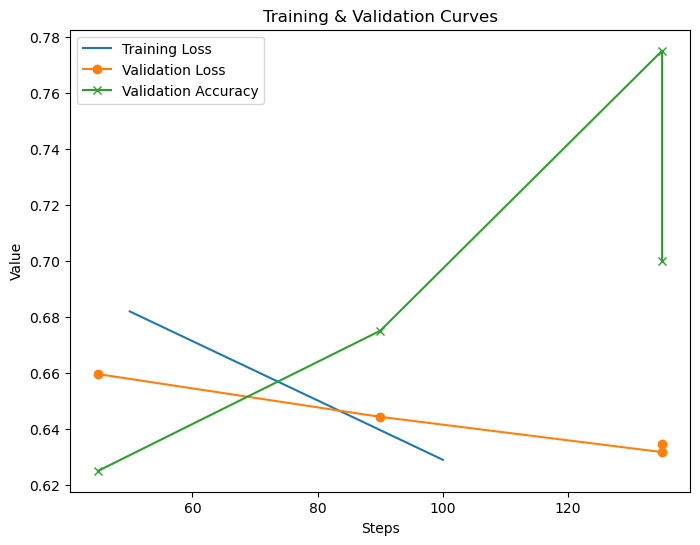

In [ ]:
# Plot the training and validation curves
logs = trainer.state.log_history # get the training log history
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []

for entry in logs:
    if "loss" in entry and "eval_loss" not in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append((entry["step"], entry["eval_accuracy"]))

plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='o')
steps_for_acc = [s for s, _ in eval_accuracy]
acc_values = [acc for _, acc in eval_accuracy]
plt.plot(steps_for_acc, acc_values, label="Validation Accuracy", marker='x')
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training & Validation Curves")
plt.legend()
plt.show()

### Model Improvement 1
Strategy: Data Augmentation, Finetuning on Attention Layer, Increase of Epochs & Introduction of Early Stopping Criteria
Reference: https://zhuanlan.zhihu.com/p/488574791

In [ ]:
# Data Augmentation for training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1) # Randomly change the brightness, contrast, saturation and hue
])

# No data augmentation for validation set
val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir, image_processor, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["file_name"]
        label = row["label"]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        processed = self.image_processor(image, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)  # (3, 224, 224)
        return {
            "pixel_values": pixel_values,
            "labels": label
        }

In [ ]:
# Process image for training and validation sets
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
train_dataset = ImageDataset(
    train_df,
    root_dir,
    image_processor=image_processor,
    transform=train_transforms
)
val_dataset = ImageDataset(
    val_df,
    root_dir,
    image_processor=image_processor,
    transform=val_transforms
)
len(train_dataset), len(val_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

(10000, 1000)

In [ ]:
# Finetuning only on the attention layer
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
for name, param in model.named_parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    # unfreeze all attention parameters
    if "attention" in name:
        param.requires_grad = True

# See the trainable parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.embeddings.cls_token False
vit.embeddings.position_embeddings False
vit.embeddings.patch_embeddings.projection.weight False
vit.embeddings.patch_embeddings.projection.bias False
vit.encoder.layer.0.attention.attention.query.weight True
vit.encoder.layer.0.attention.attention.query.bias True
vit.encoder.layer.0.attention.attention.key.weight True
vit.encoder.layer.0.attention.attention.key.bias True
vit.encoder.layer.0.attention.attention.value.weight True
vit.encoder.layer.0.attention.attention.value.bias True
vit.encoder.layer.0.attention.output.dense.weight True
vit.encoder.layer.0.attention.output.dense.bias True
vit.encoder.layer.0.intermediate.dense.weight False
vit.encoder.layer.0.intermediate.dense.bias False
vit.encoder.layer.0.output.dense.weight False
vit.encoder.layer.0.output.dense.bias False
vit.encoder.layer.0.layernorm_before.weight False
vit.encoder.layer.0.layernorm_before.bias False
vit.encoder.layer.0.layernorm_after.weight False
vit.encoder.layer.0.layernorm_aft

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir="./vit_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,       # to ensure EarlyStoppingCallback
    metric_for_best_model="accuracy",  # use accuracy for best model
    greater_is_better=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=1e-5,
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6778403520584106, 'eval_accuracy': 0.55, 'eval_f1-score': 0.5454545454545455, 'eval_runtime': 11.2887, 'eval_samples_per_second': 3.543, 'eval_steps_per_second': 0.443, 'epoch': 1.0}
{'loss': 0.6913, 'grad_norm': 0.6564904451370239, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.11}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6701211333274841, 'eval_accuracy': 0.6, 'eval_f1-score': 0.5989974937343359, 'eval_runtime': 11.1672, 'eval_samples_per_second': 3.582, 'eval_steps_per_second': 0.448, 'epoch': 2.0}
{'loss': 0.6716, 'grad_norm': 0.5606456398963928, 'learning_rate': 7.77777777777778e-06, 'epoch': 2.22}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6633040904998779, 'eval_accuracy': 0.625, 'eval_f1-score': 0.6247654784240151, 'eval_runtime': 18.0328, 'eval_samples_per_second': 2.218, 'eval_steps_per_second': 0.277, 'epoch': 3.0}
{'loss': 0.6582, 'grad_norm': 0.6562608480453491, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.33}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6571478843688965, 'eval_accuracy': 0.675, 'eval_f1-score': 0.6747967479674797, 'eval_runtime': 16.2958, 'eval_samples_per_second': 2.455, 'eval_steps_per_second': 0.307, 'epoch': 4.0}
{'loss': 0.6419, 'grad_norm': 0.8670867681503296, 'learning_rate': 5.555555555555557e-06, 'epoch': 4.44}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6517943143844604, 'eval_accuracy': 0.7, 'eval_f1-score': 0.7, 'eval_runtime': 14.5818, 'eval_samples_per_second': 2.743, 'eval_steps_per_second': 0.343, 'epoch': 5.0}
{'loss': 0.6224, 'grad_norm': 1.0310031175613403, 'learning_rate': 4.444444444444444e-06, 'epoch': 5.56}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6457396745681763, 'eval_accuracy': 0.7, 'eval_f1-score': 0.7, 'eval_runtime': 14.5412, 'eval_samples_per_second': 2.751, 'eval_steps_per_second': 0.344, 'epoch': 6.0}
{'loss': 0.6065, 'grad_norm': 0.7120507955551147, 'learning_rate': 3.3333333333333333e-06, 'epoch': 6.67}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.641169548034668, 'eval_accuracy': 0.725, 'eval_f1-score': 0.7248280175109443, 'eval_runtime': 13.9829, 'eval_samples_per_second': 2.861, 'eval_steps_per_second': 0.358, 'epoch': 7.0}
{'loss': 0.5964, 'grad_norm': 0.678148090839386, 'learning_rate': 2.222222222222222e-06, 'epoch': 7.78}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6377262473106384, 'eval_accuracy': 0.725, 'eval_f1-score': 0.7248280175109443, 'eval_runtime': 11.6226, 'eval_samples_per_second': 3.442, 'eval_steps_per_second': 0.43, 'epoch': 8.0}
{'loss': 0.5855, 'grad_norm': 0.781446635723114, 'learning_rate': 1.111111111111111e-06, 'epoch': 8.89}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.6353048086166382, 'eval_accuracy': 0.725, 'eval_f1-score': 0.7248280175109443, 'eval_runtime': 11.2893, 'eval_samples_per_second': 3.543, 'eval_steps_per_second': 0.443, 'epoch': 9.0}
{'train_runtime': 2456.4081, 'train_samples_per_second': 1.466, 'train_steps_per_second': 0.183, 'train_loss': 0.6332819138044192, 'epoch': 9.0}


  0%|          | 0/5 [00:00<?, ?it/s]

Evaluation Metrics: {'eval_loss': 0.641169548034668, 'eval_accuracy': 0.725, 'eval_f1-score': 0.7248280175109443, 'eval_runtime': 11.4731, 'eval_samples_per_second': 3.486, 'eval_steps_per_second': 0.436, 'epoch': 9.0}


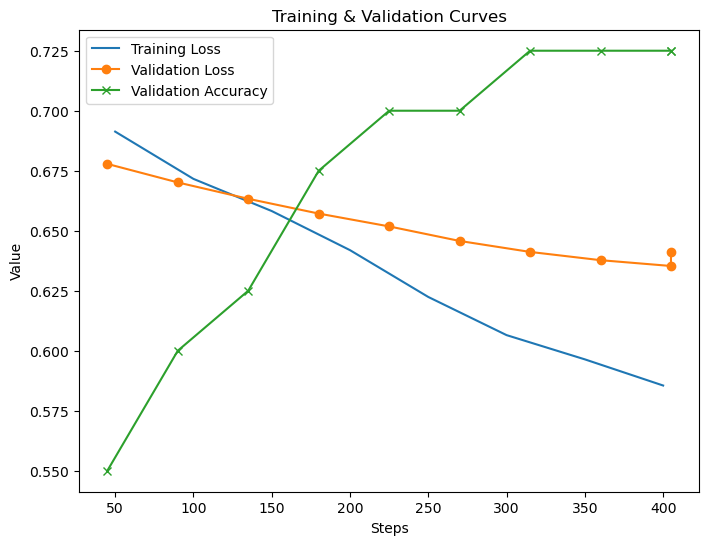

In [ ]:
# Plot the training and validation curves
logs = trainer.state.log_history # get the training log history
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []

for entry in logs:
    if "loss" in entry and "eval_loss" not in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append((entry["step"], entry["eval_accuracy"]))

plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='o')
steps_for_acc = [s for s, _ in eval_accuracy]
acc_values = [acc for _, acc in eval_accuracy]
plt.plot(steps_for_acc, acc_values, label="Validation Accuracy", marker='x')
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training & Validation Curves")
plt.legend()
plt.show()

# Model Improvement 2 (Final Model)

In [ ]:
# Data Augmentation for training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1) # Randomly change the brightness, contrast, saturation and hue
])

# No data augmentation for validation set
val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

In [ ]:
# Process image for training and validation sets
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
train_dataset = ImageDataset(
    train_df,
    root_dir,
    image_processor=image_processor,
    transform=train_transforms
)
val_dataset = ImageDataset(
    val_df,
    root_dir,
    image_processor=image_processor,
    transform=val_transforms
)
len(train_dataset), len(val_dataset)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

(71955, 7995)

In [ ]:
# Define the evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {
        "accuracy": acc,
        "f1-score": f1
    }

In [ ]:
# Finetuning only on the attention layer
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=2
)
for name, param in model.named_parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    # unfreeze the last 2 layers and all attention parameters
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "attention" in name:
        param.requires_grad = True

# See the trainable parameters
for name, param in model.named_parameters():
    print(name, param.requires_grad)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.embeddings.cls_token False
vit.embeddings.position_embeddings False
vit.embeddings.patch_embeddings.projection.weight False
vit.embeddings.patch_embeddings.projection.bias False
vit.encoder.layer.0.attention.attention.query.weight True
vit.encoder.layer.0.attention.attention.query.bias True
vit.encoder.layer.0.attention.attention.key.weight True
vit.encoder.layer.0.attention.attention.key.bias True
vit.encoder.layer.0.attention.attention.value.weight True
vit.encoder.layer.0.attention.attention.value.bias True
vit.encoder.layer.0.attention.output.dense.weight True
vit.encoder.layer.0.attention.output.dense.bias True
vit.encoder.layer.0.intermediate.dense.weight False
vit.encoder.layer.0.intermediate.dense.bias False
vit.encoder.layer.0.output.dense.weight False
vit.encoder.layer.0.output.dense.bias False
vit.encoder.layer.0.layernorm_before.weight False
vit.encoder.layer.0.layernorm_before.bias False
vit.encoder.layer.0.layernorm_after.weight False
vit.encoder.layer.0.layernorm_aft

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/dl_models/vit_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2, # save the most recent 2 epochs
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=5e-5,
    #add warmup strategy to stablize training
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
#trainer.train()
trainer.train(resume_from_checkpoint=True) # in case of reconnection, resume the checkpoint
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)
# Save the trained model
trainer.save_model("/content/drive/MyDrive/dl_models/kagglecomp_vit_final.h5")

/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:3441: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Epoch,Training Loss,Validation Loss,Accuracy,F1-score
9,0.034700,0.039430,0.991245,0.991244
10,0.019200,0.039143,0.991245,0.991244


Evaluation Metrics: {'eval_loss': 0.03667641431093216, 'eval_accuracy': 0.9917448405253283, 'eval_f1-score': 0.9917447963563769, 'eval_runtime': 84.4813, 'eval_samples_per_second': 94.636, 'eval_steps_per_second': 11.837, 'epoch': 10.0}


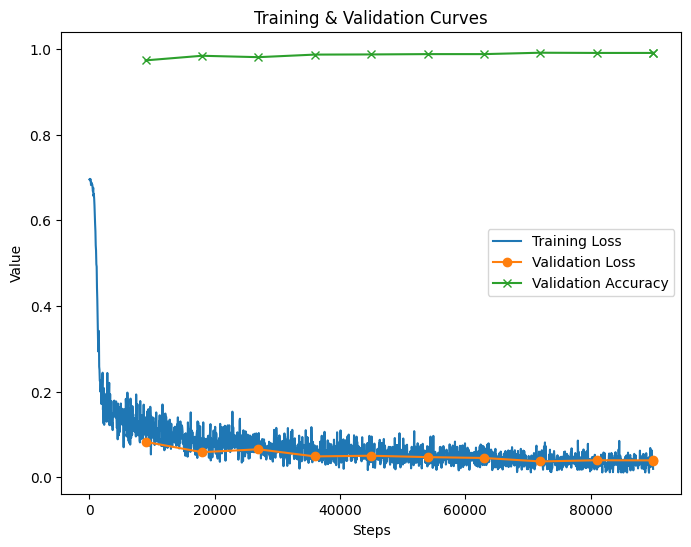

In [ ]:
# Plot the training and validation curves
logs = trainer.state.log_history # get the training log history
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []

for entry in logs:
    if "loss" in entry and "eval_loss" not in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append((entry["step"], entry["eval_accuracy"]))

plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_loss, label="Training Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker='o')
steps_for_acc = [s for s, _ in eval_accuracy]
acc_values = [acc for _, acc in eval_accuracy]
plt.plot(steps_for_acc, acc_values, label="Validation Accuracy", marker='x')
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Training & Validation Curves")
plt.legend()
plt.show()

In [ ]:
# Evaluate with hold-out test dataset (in the previous training process)
test_dataset = ImageDataset(
    test_df,
    root_dir,
    image_processor=image_processor,
    transform=val_transforms
)
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Test Metrics:", test_metrics)

Test Metrics: {'eval_loss': 0.0740237906575203, 'eval_accuracy': 0.977, 'eval_f1-score': 0.976999976999977, 'eval_runtime': 10.7967, 'eval_samples_per_second': 92.621, 'eval_steps_per_second': 11.578, 'epoch': 6.0}


## Unlabeled Test Set Prediction

In [ ]:
final_pred_df

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImagePredictionDataset(Dataset):
    def __init__(self, df, root_dir, image_processor, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["file_name"]  # 这里没有 label 列
        img_path = os.path.join(self.root_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 用 Hugging Face 的图像处理器来做 resize / normalize 等
        processed = self.image_processor(image, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)  # shape: (3, H, W)

        # 返回图像的 tensor 和可选的 ID
        return {
            "pixel_values": pixel_values,
            "id": img_name  # 也可以叫 "file_name"
        }


In [ ]:
final_pred_df

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg


In [ ]:
class ImagePredictionDataset(Dataset):
    def __init__(self, df, root_dir, image_processor, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["id"]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        processed = self.image_processor(image, return_tensors="pt")
        pixel_values = processed["pixel_values"].squeeze(0)

        return {
            "pixel_values": pixel_values,
            "id": img_name
        }

In [ ]:
# Preprocess the final_pred_df
final_pred_dataset = ImagePredictionDataset(
    final_pred_df,
    root_dir,
    image_processor=image_processor,
    transform=val_transforms
)

In [ ]:
# Predict the unlabeled test data
predictions = trainer.predict(final_pred_dataset)
predictions

PredictionOutput(predictions=array([[ 1.683264 , -1.710387 ],
       [ 2.283386 , -2.320479 ],
       [ 2.2629085, -2.3187413],
       ...,
       [ 2.2796333, -2.3309934],
       [-2.2626643,  2.2145112],
       [ 2.2764654, -2.3157172]], dtype=float32), label_ids=None, metrics={'test_runtime': 153.8906, 'test_samples_per_second': 36.0, 'test_steps_per_second': 4.503})

In [ ]:
logits = predictions.predictions  # shape: [num_samples, num_labels]
pred_labels = np.argmax(logits, axis=1)
final_pred_df["label"] = pred_labels
final_pred_df

,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,0
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,0
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,0
...,...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg,0
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg,0
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg,0
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg,1


In [ ]:
final_pred_df.to_csv("/content/drive/MyDrive/dl_models/submission.csv", index=False)